In [6]:
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 500000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

<IPython.core.display.Javascript object>

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('atlantic.csv')

###cleaning data###
df = df[df.iloc[:,10]!=-999]
df['Latitude'] = df['Latitude'].str.replace('[a-zA-Z]','').astype(float)
df['Longitude'] = df['Longitude'].str.replace('[a-zA-Z]','').astype(float)
df['Longitude'] = -1*df['Longitude'] #since the longtitude is in the west

# strip white space and create status list
df['Name'] = df['Name'].apply(lambda x: x.strip())
df['Status_Str'] = df['Status'].loc[:]
df['Status'] = df['Status'].apply(lambda x: x.strip())
status_list = list(pd.unique(df['Status']))
print(status_list)

status_dict = {'TD': 'Tropical cyclone of tropical depression intensity (< 34 knots)',  
               'TS': 'Tropical cyclone of tropical storm intensity (34-63 knots) ', 
               'HU': 'Tropical cyclone of hurricane intensity (> 64 knots)',  
               'EX': 'Extratropical cyclone (of any intensity)',  
               'SD': 'Subtropical cyclone of subtropical depression intensity (< 34 knots)',  
               'SS': 'Subtropical cyclone of subtropical storm intensity (> 34 knots)',  
               'LO': 'A low that is neither a tropical cyclone, a subtropical cyclone, nor an extratropical cyclone (of any intensity)',  
               'WV': 'Tropical Wave (of any intensity)  DB – Disturbance (of any intensity)' }

# make the status an integer value for classification
for i in range(len(status_list)):
    df['Status'].replace(status_list[i], i, inplace=True)
    
df.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

['TD', 'TS', 'HU', 'EX', 'WV', 'LO', 'SS', 'SD', 'DB']


,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Status_Str
43104,AL012004,ALEX,20040731,1800,,0,30.3,-78.3,25,1010,0,0,0,0,0,0,0,0,0,0,0,0,TD
43105,AL012004,ALEX,20040801,0,,0,31.0,-78.8,25,1009,0,0,0,0,0,0,0,0,0,0,0,0,TD
43106,AL012004,ALEX,20040801,600,,0,31.5,-79.0,25,1009,0,0,0,0,0,0,0,0,0,0,0,0,TD
43107,AL012004,ALEX,20040801,1200,,0,31.6,-79.1,30,1009,0,0,0,0,0,0,0,0,0,0,0,0,TD
43108,AL012004,ALEX,20040801,1800,,1,31.6,-79.2,35,1009,0,50,50,0,0,0,0,0,0,0,0,0,TS


In [8]:
########################
#### NN starts here ####
########################

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, TimeDistributed, Bidirectional
from tensorflow.keras import models
from sklearn.preprocessing import MinMaxScaler

feat_columns = ['Status', 'Maximum Wind', 'Minimum Pressure', 'Low Wind NE',
       'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE',
       'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW',
       'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW']

y = df.loc[:,['Latitude','Longitude']]
x = df[feat_columns[1:]].astype(np.float)
data = pd.concat([y,x], axis=1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
###########################
#### Reprocessing Data ####
###########################

#time step method 
#LSTM(RNN) method will be used and it expects 3D array. 

length = 20 #time step
data = data.to_numpy()
scaler = MinMaxScaler() #Scaling with MinMaxScaler method
data = scaler.fit_transform(data)

sequence_length = length+1
result = []

for index in range(len(data)-sequence_length):
  result.append(data[index: index+sequence_length])

result = np.array(result)
n = len(result)*0.85 #85% will be training set

train = result[:int(n), :]
x_train = train[:, 2:]
y_train_latitude = train[:, 0][:,0]
y_train_longitude = train[:, 1][:,1]
x_test = result[int(n):, 2:]
y_test_latitude = result[int(n):, 0][:,0]
y_test_longitude = result[int(n):, 1][:,1]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
#Testing different optimizer on latitude

optimizer = ['RMSprop','adadelta','adagrad','adamax','nadam']

for opt in optimizer:
  model = Sequential()
  model.add(LSTM(units = 128, return_sequences = True, dropout = 0.05, input_shape=(x_train.shape[1], x_train.shape[2])))
  model.add(LSTM(units = 32, return_sequences = False, dropout = 0.05))
  model.add(Dense(1))
  model.add(Activation('relu'))
  model.compile(loss='mse', optimizer=opt)
  history = model.fit(x_train, y_train_latitude, batch_size=3, epochs=10, validation_data=(x_test, y_test_latitude))

  print('Optimizer', opt)

  trainScore = model.evaluate(x_train, y_train_latitude, verbose=0)
  print('Train Score: %.4f MSE' % (trainScore))

  testScore = model.evaluate(x_test, y_test_latitude, verbose=0)
  print('Test Score: %.4f MSE' % (testScore))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/10
1672/1672 [==============================] - 42s 22ms/step - loss: 0.0231 - val_loss: 0.0169
Epoch 2/10
1672/1672 [==============================] - 37s 22ms/step - loss: 0.0136 - val_loss: 0.0101
Epoch 3/10
1672/1672 [==============================] - 37s 22ms/step - loss: 0.0120 - val_loss: 0.0102
Epoch 4/10
1672/1672 [==============================] - 36s 22ms/step - loss: 0.0123 - val_loss: 0.0089
Epoch 5/10
1672/1672 [==============================] - 36s 22ms/step - loss: 0.0106 - val_loss: 0.0077
Epoch 6/10
1672/1672 [==============================] - 38s 23ms/step - loss: 0.0096 - val_loss: 0.0091
Epoch 7/10
1672/1672 [==============================] - 38s 23ms/step - loss: 0.0091 - val_loss: 0.0075
Epoch 8/10
1672/1672 [==============================] - 38s 23ms/step - loss: 0.0079 - val_loss: 0.0076
Epoch 9/10
1672/1672 [==============================] - 37s 22ms/step - loss: 0.0088 - val_loss: 0.0078
Epoch 10/10
1672/1672 [==============================] - 37s 22m

In [11]:
#Base on the result above, any optimizer would work fine with relu. 
#Choosing 'adagrad' just to visualize loss changes over 200 epoch. Other optimizer needs only 20-30 epoch.
#Note, it is not ideal to choose adagrad for this problem.


def RNN(x_train, y_train, x_test, y_test, epoch):
  model = Sequential()
  model.add(LSTM(units = 128, return_sequences = True, dropout = 0.05, input_shape=(x_train.shape[1], x_train.shape[2])))
  model.add(LSTM(units = 32, return_sequences = False, dropout = 0.05))
  model.add(Dense(1))
  model.add(Activation('relu'))
  model.compile(loss='mse', optimizer='adagrad')
  history = model.fit(x_train, y_train, batch_size=3, epochs=epoch, validation_data=(x_test, y_test))

  trainScore = model.evaluate(x_train, y_train_latitude, verbose=0)
  print('Train Score: %.4f MSE' % (trainScore))

  testScore = model.evaluate(x_test, y_test_latitude, verbose=0)
  print('Test Score: %.4f MSE' % (testScore))

  y_pred = model.predict(x_test)

  return y_pred, history.history['loss'], history.history['val_loss']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
y_pred_long, loss_long, val_loss_long = RNN(x_train, y_train_longitude, x_test, y_test_longitude, 200)
y_pred_lat, loss_lat, val_loss_lat = RNN(x_train, y_train_latitude, x_test, y_test_latitude, 200)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/200
1672/1672 [==============================] - 40s 22ms/step - loss: 0.0464 - val_loss: 0.0360
Epoch 2/200
1672/1672 [==============================] - 35s 21ms/step - loss: 0.0298 - val_loss: 0.0333
Epoch 3/200
1672/1672 [==============================] - 35s 21ms/step - loss: 0.0254 - val_loss: 0.0308
Epoch 4/200
1672/1672 [==============================] - 35s 21ms/step - loss: 0.0240 - val_loss: 0.0289
Epoch 5/200
1672/1672 [==============================] - 35s 21ms/step - loss: 0.0238 - val_loss: 0.0282
Epoch 6/200
1672/1672 [==============================] - 35s 21ms/step - loss: 0.0210 - val_loss: 0.0258
Epoch 7/200
1672/1672 [==============================] - 35s 21ms/step - loss: 0.0200 - val_loss: 0.0246
Epoch 8/200
1672/1672 [==============================] - 36s 21ms/step - loss: 0.0181 - val_loss: 0.0230
Epoch 9/200
1672/1672 [==============================] - 38s 23ms/step - loss: 0.0178 - val_loss: 0.0213
Epoch 10/200
1672/1672 [==============================]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

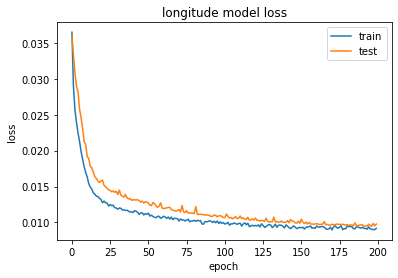

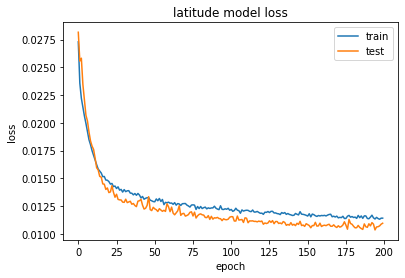

In [13]:
ax1 = plt.figure()
plt.plot(loss_long)
plt.plot(val_loss_long)
plt.title('longitude model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper right')
plt.show()

ax2 = plt.figure()
plt.plot(loss_lat)
plt.plot(val_loss_lat)
plt.title('latitude model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper right')
plt.show()

In [14]:
latitude_predictions_scaled = scaler.inverse_transform([[Latitude[0],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] for Latitude in y_pred_lat])
longitude_predictions_scaled = scaler.inverse_transform([[0,Longitude[0],0,0,0,0,0,0,0,0,0,0,0,0,0,0] for Longitude in y_pred_long])
lat_prediction = latitude_predictions_scaled[:,0]
long_prediction = longitude_predictions_scaled[:,1]

data_to_visualize = df.iloc[-y_test_latitude.shape[0]-sequence_length:-sequence_length]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
dataframe = pd.DataFrame(data_to_visualize[['Name','Latitude','Longitude']])
dataframe['Lat_pred']= lat_prediction
dataframe['Long_pred'] = long_prediction

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
!apt-get install -q libgeos-3.5.0
!apt-get install -q libgeos-dev
!pip install -q https://github.com/matplotlib/basemap/archive/master.zip

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reading package lists...
Building dependency tree...
Reading state information...
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists...
Building dependency tree...
Reading state information...
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [ ]:
from mpl_toolkits.basemap import Basemap

In [ ]:
names = pd.unique(dataframe['Name'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

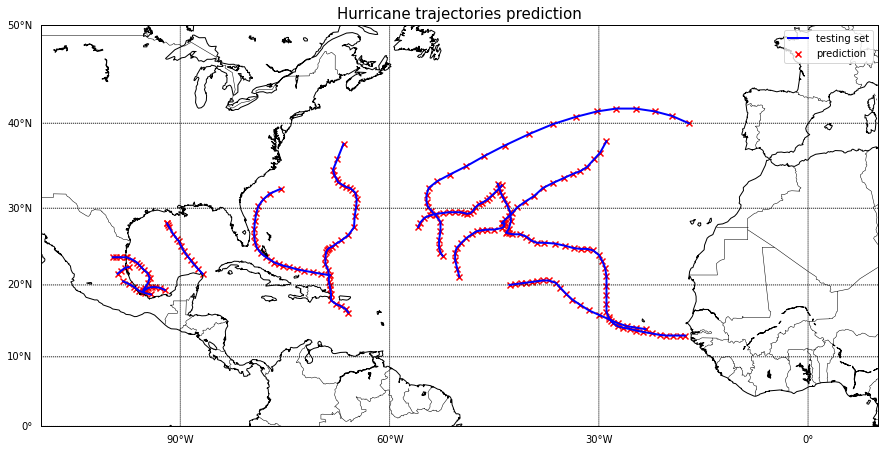

In [19]:
#######################
#### Visualization ####
#######################

# plot 10 hurricanes in testing dataset vs prediction

plt.figure(figsize=(15,10))
m = Basemap(llcrnrlon=-110.,llcrnrlat=0.,urcrnrlon=10.,urcrnrlat=50.,
            rsphere=(6378137.00,6356752.3142),
            resolution='l',
            projection='merc',
            lat_0=40.,lon_0=-20.,lat_ts=20.)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
m.drawparallels(np.arange(-90,90,10),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180,180,30),labels=[0,0,0,1])

for i in range(len(names)):
    if i <= 10:
        lat, long = dataframe[dataframe['Name']==names[i]]['Latitude'], dataframe[dataframe['Name']==names[i]]['Longitude']
        xpt, ypt = m(np.array(long), np.array(lat))
        testing, = m.plot(xpt, ypt, linewidth=2, color='blue')
        pred_lat, pred_long = dataframe[dataframe['Name']==names[i]]['Lat_pred'], dataframe[dataframe['Name']==names[i]]['Long_pred']
        xpt_, ypt_ = m(np.array(pred_long), np.array(pred_lat))
        prediction = m.scatter(xpt, ypt, color='red', marker='x')
    else:
        break

plt.title('Hurricane trajectories prediction', fontsize=15)
plt.legend([testing, prediction],['testing set','prediction'],loc='upper right')
plt.show()

# New Section